<a href="https://colab.research.google.com/github/TomokiNishida/AirRideGame/blob/master/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
cp gdrive/My\ Drive/points_3d.pkl points_3d.pkl

In [0]:
#functions
from chainer import cuda
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def carculate_len(data3d, bones, device):
    xp = np if device < 0 else cuda.cupy
    skeletal_len = xp.empty((0), dtype = 'float32')
    for start,end in bones:
        bone_len = xp.mean(xp.linalg.norm(data3d[:,3*start:3*(start+1)]-data3d[:,3*end:3*(end+1)], axis = 1))
        skeletal_len =  xp.concatenate((skeletal_len, xp.array([bone_len], dtype = 'float32')), axis = 0)
    return skeletal_len

def normalization(data3d,scale):
    for points in data3d:
        points[0::3] = points[0::3] - (points[0::3].max()+points[0::3].min())/2.0
        points[1::3] = points[1::3] - (points[1::3].max()+points[1::3].min())/2.0
        points[2::3] = points[2::3] - (points[2::3].max()+points[2::3].min())/2.0
    if scale <= 0:
        scale = (data3d.max()-data3d.min())/2.0
    data3d = (data3d-(data3d.max()+data3d.min())/2.0)/scale
    return data3d, scale

def random_rotation(data3d,device):
    xp = np if device < 0 else cuda.cupy
    data3d_rot =  xp.empty((0, data3d.shape[1]), dtype = 'float32')
    for points in data3d:
        yaw = 2*xp.pi*xp.random.rand()
        sin = xp.sin(yaw)
        cos = xp.sqrt(1-sin**2)
        r = xp.array([[cos,sin,0],[-sin,cos,0],[0,0,1]], dtype = 'float32')
        xyz = points.reshape(-1,3)
        points = xyz.dot(r).reshape(-1)
        data3d_rot = xp.concatenate((data3d_rot, xp.array([points], dtype = 'float32')), axis = 0)
    return data3d_rot

def rotation(data3d,yaw,device):
    xp = np if device < 0 else cuda.cupy
    data3d_rot =  xp.empty((0, data3d.shape[1]), dtype = 'float32')
    for points in data3d:
        yaw = 2*xp.pi*yaw
        sin = xp.sin(yaw)
        cos = xp.sqrt(1-sin**2)
        r = xp.array([[cos,sin,0],[-sin,cos,0],[0,0,1]], dtype = 'float32')
        xyz = points.reshape(-1,3)
        points = xyz.dot(r).reshape(-1)
        data3d_rot = xp.concatenate((data3d_rot, xp.array([points], dtype = 'float32')), axis = 0)
    return data3d_rot

def projection(data3d):
    n_points = data3d.shape[1]//3
    index=[]
    for point in range(n_points):
        index.append(3*point+1)
        index.append(3*point+2)
    return data3d[:,index]

def lift(data1d,data2d,device):
    xp = np if device < 0 else cuda.cupy
    n_points = data1d.shape[1]
    data3d = xp.empty((0, 3*n_points), dtype = 'float32')
    for index in range(data1d.shape[0]):
        p3d = xp.hstack((xp.array([data1d[index]], dtype = 'float32').T, data2d[index].reshape(-1,2)))
        data3d = xp.concatenate((data3d, xp.array([p3d.reshape(-1)], dtype = 'float32')), axis = 0)
    return data3d

def visualize(data3d_real, data3d_fake, bones, scale):
    data3d_real = data3d_real * scale + scale
    data3d_fake = data3d_fake * scale + scale
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.set_xlim(0, 2*scale)
    ax.set_ylim(0, 2*scale)
    ax.set_zlim(0, 2*scale)
    for start,end in bones:
        ax.plot([data3d_fake[3*start], data3d_fake[3*end]],
                [data3d_fake[3*start+1], data3d_fake[3*end+1]],
                [data3d_fake[3*start+2], data3d_fake[3*end+2]],
                "-",color = "#aa0000")
    for start,end in bones:
        ax.plot([data3d_real[3*start], data3d_real[3*end]],
                [data3d_real[3*start+1], data3d_real[3*end+1]],
                [data3d_real[3*start+2], data3d_real[3*end+2]],
                "-",color = "#0000aa")
    plt.show()


In [0]:
#dataset
from chainer import cuda
import numpy as np
import pickle
import chainer

class Human36M(chainer.dataset.DatasetMixin):
    def __init__(self, person='S1',
                actions=['Directions', 'WalkingDog', 'Eating 2', 'Posing',
                'Smoking 1', 'Phoning', 'TakingPhoto 1', 'Waiting', 'Walking 1',
                'Purchases 1', 'Eating', 'Phoning 1', 'TakingPhoto', 'Directions 1',
                'SittingDown 2', 'Discussion 1', 'Posing 1', 'WalkTogether 1', 'Purchases',
                'SittingDown', 'Smoking', 'Greeting 1', 'Sitting 1', 'Sitting 2', 'WalkTogether',
                'Waiting 1', 'WalkingDog 1', 'Greeting', 'Discussion', 'Walking'],
                points = [0,1,2,3,6,7,8,12,13,14,15,17,18,19,25,26,27],
                bones = [[0,1],[1,2],[2,3],[0,4],[4,5],[5,6],[0,7],[7,8],
                             [8,9],[9,10],[8,11],[11,12],[12,13],[8,14],[14,15],[15,16]],
                scale = -1,
                device = 0):
        
        with open("points_3d.pkl","rb") as f:
            p3d = pickle.load(f)
        points_index = []
        for point in points:
            points_index.append(3*point)
            points_index.append(3*point+1)
            points_index.append(3*point+2)
        data3d = np.empty((0, 3*len(points)), dtype = 'float32')
        for action in actions:
            data3d = np.append(data3d, np.array(p3d[person][action][:,points_index]), axis = 0)
        if device >= 0:
            data3d = cuda.cupy.asarray(data3d)
        data3d = random_rotation(data3d,device)
        data3d,scale = normalization(data3d,scale)
        self.data3d = data3d
        self.scale = scale
        self.data2d = projection(data3d)
        self.bones = bones
        self.skeletal_len = carculate_len(data3d,bones,device)
        self.N = 2*len(points)

    def __len__(self):
        return self.data3d.shape[0]

    def get_example(self, i):
        return self.data2d[i], self.data3d[i]


In [0]:
#evaluator
import chainer
from chainer import reporter as reporter_module
import chainer.functions as F
from chainer.training import extensions
import copy


class Evaluator(extensions.Evaluator):
    def __init__(self,  bones, scale, *args, **kwargs):
        self.bones = bones
        self.scale = scale
        
        super(Evaluator, self).__init__(*args, **kwargs)
        
    def evaluate(self):
        iterator = self._iterators['main']
        gen = self._targets['gen']
        if self.eval_hook:
            self.eval_hook(self)
        if hasattr(iterator, 'reset'):
            iterator.reset()
            it = iterator
        else:
            it = copy.copy(iterator)

        for batch in it:
            proj, xyz = self.converter(batch, self.device)
            proj_real = Variable(proj)
            z_pred = gen(proj_real)
            xyz_pred = lift(z_pred.array,proj, self.device)
            visualize(xyz[0],xyz_pred[0],self.bones,self.scale)
        return {}

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L

"""
class MLPResBlock(chainer.Chain):
    def __init__(self, n_units):
        super(MLPResBlock, self).__init__()
        w = chainer.initializers.Normal(0.02)
        with self.init_scope():
            self.l1 = L.Linear(n_units, n_units,initialW=w)
            self.bn1 = L.BatchNormalization(n_units)
            self.l2 = L.Linear(n_units, n_units,initialW=w)
            self.bn2 = L.BatchNormalization(n_units)

    def __call__(self, x):
        h = F.relu(self.bn1(self.l1(x)))
        h = F.relu(self.bn2(self.l2(h)))
        return F.relu(x + h)

class MLPResNet(chainer.Chain):
    def __init__(self, block_class, isGen, n_in, layers=2, n_units=1024):
        super(MLPResNet, self).__init__()
        w = chainer.initializers.Normal(0.02)
        with self.init_scope():
            self.isGen = isGen
            n_out = n_in//2 if isGen else 1
            links = [('l1', L.Linear(n_in, n_units,initialW=w))]
            links += [('bn1', L.BatchNormalization(n_units))]
            for i in range(layers):
                links += [('res{}'.format(len(links)),block_class(n_units))]
            links += [('l2', L.Linear(n_units, n_out,initialW=w))]
            self.forward = links

    def __call__(self, x):
        for name, f in self.forward:
            x = f(x)
        return F.tanh(x) if self.isGen else x
"""

class MLPResNet(chainer.Chain):
    def __init__(self, isGen, n_in, n_units=1024):
        super(MLPResNet, self).__init__()
        w = chainer.initializers.Normal(0.02)
        with self.init_scope():
            self.isGen = isGen
            n_out = n_in//2 if isGen else 1
            self.l0 = L.Linear(n_in, n_units,initialW=w)
            self.bn0 = L.BatchNormalization(n_units) 
            self.l1 = L.Linear(n_units, n_units,initialW=w)
            self.bn1 = L.BatchNormalization(n_units)
            self.l2 = L.Linear(n_units, n_units,initialW=w)
            self.bn2 = L.BatchNormalization(n_units)
            self.l3 = L.Linear(n_units, n_units,initialW=w)
            self.bn3 = L.BatchNormalization(n_units)
            self.l4 = L.Linear(n_units, n_units,initialW=w)
            self.bn4 = L.BatchNormalization(n_units)
            self.l5 = L.Linear(n_units, n_out,initialW=w)
    
    def __call__(self, x):
        x = F.leaky_relu(self.bn0(self.l0(x)))
        h = F.leaky_relu(self.bn1(self.l1(x)))
        h = self.bn2(self.l2(h))
        x = F.leaky_relu(x + h)
        h = F.leaky_relu(self.bn3(self.l3(x)))
        h = self.bn4(self.l4(h))
        x = F.leaky_relu(x + h)
        x = self.l5(x)
        return x

class MLPResNetDis(chainer.Chain):
    def __init__(self, isGen, n_in, n_units=1024):
        super(MLPResNetDis, self).__init__()
        w = chainer.initializers.Normal(0.02)
        with self.init_scope():
            self.isGen = isGen
            n_out = n_in//2 if isGen else 1
            self.l0 = L.Linear(n_in, n_units,initialW=w)
            self.bn0 = L.BatchNormalization(n_units) 
            self.l1 = L.Linear(n_units, n_units,initialW=w)
            self.bn1 = L.BatchNormalization(n_units)
            self.l2 = L.Linear(n_units, n_units,initialW=w)
            self.bn2 = L.BatchNormalization(n_units)
            self.l5 = L.Linear(n_units, n_out,initialW=w)
    
    def __call__(self, x):
        x = F.dropout(F.leaky_relu(self.bn0(self.l0(x))))
        h = F.dropout(F.leaky_relu(self.bn1(self.l1(x))))
        h = F.dropout(self.bn2(self.l2(h)))
        x = self.l5(x)
        return x


      

In [0]:
#Updator
import chainer
import chainer.functions as F
import numpy as np
from chainer import Variable
from chainer import cuda


class CustomUpdater(chainer.training.StandardUpdater):
    def __init__(self, gan_accuracy_cap, bones, skeletal_len, scale,  *args, **kwargs):
        self.gan_accuracy_cap = gan_accuracy_cap
        self.bones = bones
        self.skeletal_len = skeletal_len
        self.scale = scale
        
        self.distrigger = 0
        
        super(CustomUpdater, self).__init__(*args, **kwargs)


    def update_core(self):
        xp = np if self.device < 0 else cuda.cupy
        
        gen_optimizer = self.get_optimizer('gen')
        dis_optimizer = self.get_optimizer('dis')
        gen, dis = gen_optimizer.target, dis_optimizer.target

        batch = self.get_iterator('main').next()
        

        proj, xyz = self.converter(batch, self.device)
        proj_real = Variable(proj)
        z_pred = gen(proj_real)
        z_mse = F.mean_absolute_error(z_pred, xyz[:,0::3]) * self.scale
        xyz_pred = lift(z_pred.array, proj, self.device)
        proj_pred = Variable(projection(random_rotation(xyz_pred, self.device)))
        skeletal_len_pred = carculate_len(xyz_pred, self.bones, self.device)
        len_loss = xp.average(xp.abs(skeletal_len_pred - self.skeletal_len)/self.skeletal_len)

        p_real = dis(proj_real)
        p_fake = dis(proj_pred)
        loss_gen = F.average(F.softplus(-p_fake)) #+ len_loss
        loss_dis = F.average(F.softplus(p_fake)) + F.average(F.softplus(-p_real))
        
        acc_dis_fake = F.binary_accuracy(p_fake, dis.xp.zeros(p_fake.data.shape, dtype=int))
        acc_dis_real = F.binary_accuracy(p_real, dis.xp.ones(p_real.data.shape, dtype=int))
        acc_dis = (acc_dis_fake + acc_dis_real) / 2
        """
        gen.cleargrads()
        loss_gen.backward()
        gen_optimizer.update()
        proj_pred.unchain_backward()
        dis.cleargrads()
        loss_dis.backward()
        dis_optimizer.update()
        """
        gen.cleargrads()
        z_mse.backward()
        gen_optimizer.update()
        

        chainer.report({'loss': loss_gen, 'z_mse':z_mse, 'len_loss': len_loss}, gen)
        chainer.report({'loss': loss_dis, 'acc': acc_dis, 'acc/fake': acc_dis_fake,'acc/real': acc_dis_real}, dis)


In [0]:
import chainer
import chainer.functions as F
from chainer import training
from chainer import cuda
from chainer.training import extensions
from chainer.datasets import split_dataset_random
import numpy as np
import argparse
import multiprocessing
import os
import time


def create_result_dir(dirname):
    if not os.path.exists('results'):
        os.mkdir('results')
    if dirname:
        result_dir = os.path.join('results', dirname)
    else:
        result_dir = os.path.join(
            'results', time.strftime('%Y-%m-%d_%H-%M-%S'))
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    return result_dir

def main():
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('-g', '--gpu', type=int, default=0)
    parser.add_argument('-b', '--batchsize', type=int, default=16)
    parser.add_argument('-B', '--test_batchsize', type=int, default=32)
    parser.add_argument('-o', '--out', type=str, default='')
    parser.add_argument('-e', '--epoch', type=int, default=20)
    args = parser.parse_args()
    args.out = create_result_dir(args.out)
    """
    gpu = 0
    batchsize = 16
    test_batchsize = 2048
    epoch = 20
    out = create_result_dir('')

    h36m = Human36M(device = gpu)
    train, test = split_dataset_random(h36m, int(len(h36m) * 0.7), seed=0)
    print('TRAIN: {}, TEST: {}'.format(len(train), len(test)))
    bones = h36m.bones
    skeletal_len = h36m.skeletal_len
    scale = h36m.scale

    gen = MLPResNetDis(True, h36m.N)
    dis = MLPResNetDis(False, h36m.N)
    
    if gpu >= 0:
      chainer.cuda.get_device_from_id(gpu).use()
      gen.to_gpu()
      dis.to_gpu()

    def make_optimizer(model):
        optimizer = chainer.optimizers.Adam(alpha=2e-4)
        optimizer.setup(model)
        optimizer.add_hook(chainer.optimizer.WeightDecay(1e-5))
        return optimizer

    opt_gen = make_optimizer(gen)
    opt_dis = make_optimizer(dis)

    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    test_iter = chainer.iterators.SerialIterator(test, test_batchsize, repeat=False, shuffle=False)

    updater = CustomUpdater(gan_accuracy_cap = 0.9, bones = bones, skeletal_len = skeletal_len, scale = scale,
                            iterator={'main': train_iter, 'test': test_iter},
                            optimizer={'gen': opt_gen, 'dis': opt_dis}, device=gpu)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out=out)

    trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
    trainer.extend(extensions.PlotReport(['gen/loos'], x_key='epoch', file_name='genloss.png'))
    trainer.extend(extensions.PlotReport(['dis/loss'], x_key='epoch', file_name='disloss.png'))
    trainer.extend(extensions.PlotReport(['gen/z_mse'], x_key='epoch', file_name='gen_mse.png'))
    trainer.extend(extensions.PlotReport(['dis/len_loss'], x_key='epoch', file_name='lenloss.png'))
    trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'gen/loss', 'dis/loss', 'gen/z_mse', 'gen/len_loss','dis/acc/fake','dis/acc/real']),trigger=(1, 'epoch'))
    trainer.extend(Evaluator(bones = bones,scale = scale, iterator = test_iter, target = {'gen': gen}, device=gpu),trigger=(20, 'epoch'))


    trainer.run()

TRAIN: 43465, TEST: 18629
epoch       iteration   gen/loss    dis/loss    gen/z_mse   gen/len_loss  dis/acc/fake  dis/acc/real
1           2717        0.661821    1.47341     148.567     0.383692      0.376288      0.622217      
2           5434        0.66174     1.46917     83.1051     0.041808      0.378428      0.625805      
3           8150        0.659903    1.47031     79.9938     0.0403767     0.37378       0.629671      
4           10867       0.660304    1.47117     77.9523     0.0393931     0.37707       0.62569       
5           13583       0.660891    1.46838     76.4094     0.0389325     0.377462      0.628222      
6           16300       0.660157    1.47002     75.456      0.0389022     0.377392      0.626472      
7           19016       0.661128    1.4695      74.4512     0.0383098     0.376082      0.626197      
8           21733       0.661139    1.47078     73.7442     0.0382483     0.379164      0.627323      
9           24450       0.659286    1.47153     7

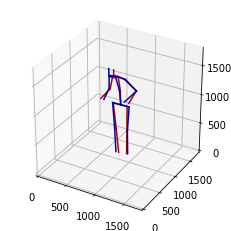

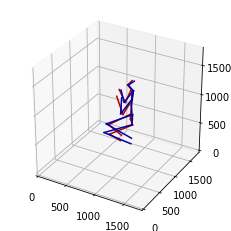

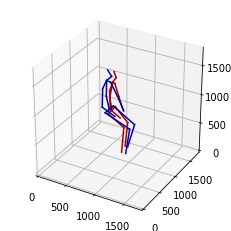

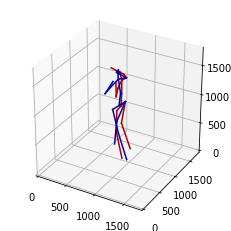

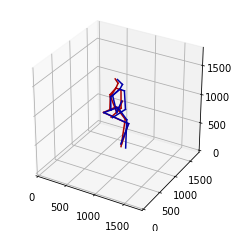

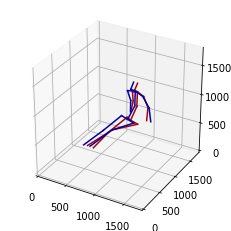

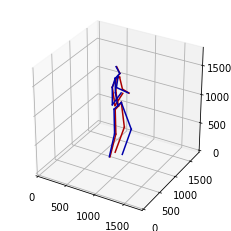

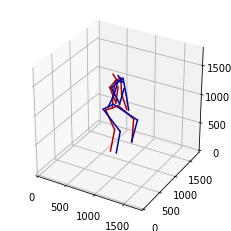

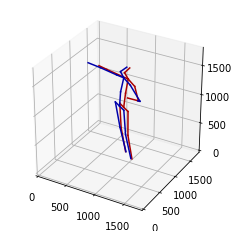

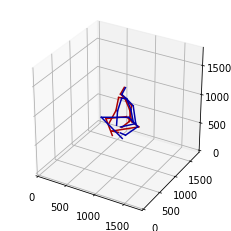

20          54332       0.659812    1.47103     70.1693     0.0381297     0.376978      0.626127      


In [15]:
main()

In [0]:
!ls results/2019-06-24_05-53-42/

In [0]:
cp results/2019-06-24_05-53-42/ gdrive/My\ Drive/results -r

In [31]:
xp = cuda.cupy
x =Variable(xp.array([[ 0.57204604],
          [ 1.092242  ],
          [ 0.31172273],
          [ 0.94880724],
          [ 2.1965058 ],
          [-0.18876854],
          [ 1.865942  ],
          [ 0.38672644],
          [ 1.4372058 ],
          [ 1.0403423 ],
          [ 0.4779226 ],
          [ 0.06718253],
          [ 0.79328775],
          [ 0.67666984],
          [ 0.6589226 ],
          [-0.5792029 ]], dtype = "float32"))
F.sum(x)/16

variable(0.73484707)